<a href="https://colab.research.google.com/github/krishnatejak2/EVA4/blob/master/Session%205/EVA4_S5_F5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Basic Code + Network Structure + Less channels + GAP + BN + Dropout**  

**Aim :**  
1. 99.4% (this must be consistently shown in your last few epochs, and not a one-time achievement) **Pending**
2. Less than or equal to 15 Epochs **Done**   
3. Less than 10000 Parameters **Done**  

**Achieved :**  

1. Less than 10000 Parameters   
2. Decreased the number of channels   
3. Added GAP layer  
4. Added BN in each layer  
5. BN is done before the activation  
6. Dropout is done after the activation  
7. RF >> image size in this scenario (final RF = 34)

**Results :**  

1. Epochs : **15**  
2. Parameters : **9,710**  
3. Best Train Accuracy : **98.37**  
4. Best Test Accuracy : **99.25**  

**Analysis :**  

1. The training can be pushed further to achieve the 99.4% in test accuracy. 
2. The model when pushed to > 15 epochs gives promising results.  
3. Accuracy improved to more than 97% in the initial epochs itself.  

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomResizedCrop(28,),
                                      #  transforms.RandomErasing(0.1),
                                       transforms.RandomRotation((-5.0, 5.0), fill=(1,)), 
                                       transforms.RandomHorizontalFlip(0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                      #  
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


 - mean: tensor(33.3100)
 - std: tensor(78.5675)
 - var: tensor(6172.8506)
torch.Size([64, 1, 28, 28])
torch.Size([64])


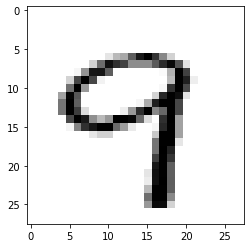

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train.train_data))
print(' - max:', torch.max(train.train_data))
print(' - mean:', torch.mean(train.train_data.type(torch.float32)))
print(' - std:', torch.std(train.train_data.type(torch.float32)))
print(' - var:', torch.var(train.train_data.type(torch.float32)))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

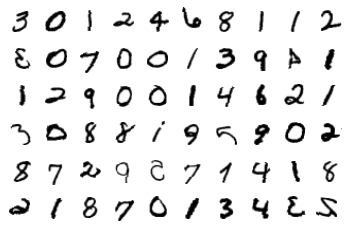

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [7]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
         # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 24, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) 
        # output_size = 11, RF = 6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12, RF = 6

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 10, RF = 10

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 10, RF = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1,bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 10, RF = 16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 10, RF = 18
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 10, RF = 22

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 34


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
       BatchNorm2d-6           [-1, 20, 24, 24]              40
           Dropout-7           [-1, 20, 24, 24]               0
              ReLU-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,080
      BatchNorm2d-12           [-1, 12, 10, 10]              24
          Dropout-13           [-1, 12, 10, 10]               0
             ReLU-14           [-1

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [11]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9,)
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.33171483874320984 Batch_id=937 Accuracy=90.16: 100%|██████████| 938/938 [00:16<00:00, 56.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0856, Accuracy: 9744/10000 (97.44%)

EPOCH: 1


Loss=0.041522979736328125 Batch_id=937 Accuracy=95.92: 100%|██████████| 938/938 [00:15<00:00, 58.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0680, Accuracy: 9791/10000 (97.91%)

EPOCH: 2


Loss=0.040867313742637634 Batch_id=937 Accuracy=96.71: 100%|██████████| 938/938 [00:15<00:00, 59.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9843/10000 (98.43%)

EPOCH: 3


Loss=0.05243934690952301 Batch_id=937 Accuracy=97.30: 100%|██████████| 938/938 [00:15<00:00, 59.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9876/10000 (98.76%)

EPOCH: 4


Loss=0.0058709681034088135 Batch_id=937 Accuracy=97.45: 100%|██████████| 938/938 [00:15<00:00, 59.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9879/10000 (98.79%)

EPOCH: 5


Loss=0.008054748177528381 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:15<00:00, 59.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9883/10000 (98.83%)

EPOCH: 6


Loss=0.25706472992897034 Batch_id=937 Accuracy=97.73: 100%|██████████| 938/938 [00:15<00:00, 60.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9883/10000 (98.83%)

EPOCH: 7


Loss=0.020230069756507874 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:15<00:00, 60.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9871/10000 (98.71%)

EPOCH: 8


Loss=0.2559555172920227 Batch_id=937 Accuracy=98.12: 100%|██████████| 938/938 [00:15<00:00, 60.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9886/10000 (98.86%)

EPOCH: 9


Loss=0.0032906830310821533 Batch_id=937 Accuracy=98.12: 100%|██████████| 938/938 [00:15<00:00, 60.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9887/10000 (98.87%)

EPOCH: 10


Loss=0.022255688905715942 Batch_id=937 Accuracy=98.10: 100%|██████████| 938/938 [00:15<00:00, 61.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9909/10000 (99.09%)

EPOCH: 11


Loss=0.06295017898082733 Batch_id=937 Accuracy=98.20: 100%|██████████| 938/938 [00:15<00:00, 61.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9888/10000 (98.88%)

EPOCH: 12


Loss=0.01693052053451538 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [00:15<00:00, 61.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.10669374465942383 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:15<00:00, 61.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9899/10000 (98.99%)

EPOCH: 14


Loss=0.011288836598396301 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:15<00:00, 60.96it/s]



Test set: Average loss: 0.0225, Accuracy: 9925/10000 (99.25%)



Text(0.5, 1.0, 'Test Accuracy')

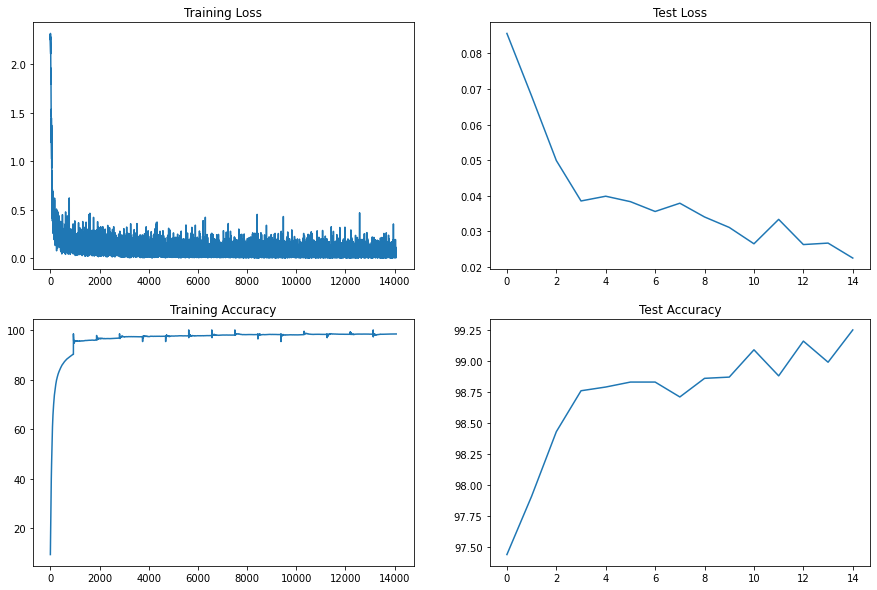

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")